In [11]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = ""  # Force CPU before importing JAX

import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
from diffrax import diffeqsolve, Dopri5, SaveAt, ODETerm

# --- Model definition (must match training) ---
class RHS(eqx.Module):
    mlp: eqx.nn.MLP
    def __init__(self, key):
        self.mlp = eqx.nn.MLP(in_size=265, out_size=262, width_size=512, depth=4, key=key)

    def __call__(self, P, H, rho, z):
        x = jnp.concatenate([P, H, rho, z])
        return self.mlp(x)

# --- Paths ---
z_idx = 0
model_file = f"/srv/scratch2/taylor.4264/odd_emu/production_models/learned_model_rhom_zchunk_{z_idx:02d}.eqx"
parent_dir = "/srv/scratch2/taylor.4264/odd_emu/production_run/merged/"

# --- Load model ---
model_template = RHS(jax.random.PRNGKey(0))
model = eqx.tree_deserialise_leaves(model_file, model_template)

# --- Load data ---
z_grid = jnp.load(os.path.join(parent_dir, f"z_{z_idx}.npy"))
Hz_full = jnp.load(os.path.join(parent_dir, f"Hz_{z_idx}.npy")).astype(jnp.float32)
rho_m_full = jnp.load(os.path.join(parent_dir, f"rho_m_{z_idx}.npy")).astype(jnp.float32)

# --- Normalization of H(z) ---
H_flat = Hz_full.reshape(-1)
H_mean = jnp.mean(H_flat)
H_std = jnp.std(H_flat)
Hz = (Hz_full[0] - H_mean) / H_std

# --- Normalization of log10(rho_m) ---
log_rho_flat = jnp.log10(rho_m_full.reshape(-1) + 1e-30)
log_rho_mean = jnp.mean(log_rho_flat)
log_rho_std = jnp.std(log_rho_flat)
log_rho_m = (jnp.log10(rho_m_full[0] + 1e-30) - log_rho_mean) / log_rho_std

# --- Flip redshift for forward integration ---
z_grid = z_grid[::-1]
Hz = Hz[::-1]
log_rho_m = log_rho_m[::-1]

# --- Interpolators ---
def H_fn(z):
    return jnp.interp(z, z_grid, Hz)

def rhom_fn(z):
    return jnp.interp(z, z_grid, log_rho_m)

# --- Initial condition (lowest redshift, i.e., highest index) ---
pk0 = jnp.load(os.path.join(parent_dir, f"pk_nl_{z_idx}.npy"))[0, -1]
y0 = jnp.log1p(pk0)

# --- Define RHS for ODE integration ---
def rhs(t, y, args):
    model, H_fn, rhom_fn = args
    H = H_fn(t)
    rho = rhom_fn(t)
    z = jnp.array([t])
    return model(y, jnp.array([H]), jnp.array([rho]), z)

# --- Setup ODE solver ---
term = ODETerm(rhs)
solver = Dopri5()
saveat = SaveAt(ts=z_grid)

print("Initial z:", float(z_grid[0]))
print("Final z:", float(z_grid[-1]))
print("H(z) range:", H_fn(z_grid).min(), H_fn(z_grid).max())
print("rho_m(z) range:", rhom_fn(z_grid).min(), rhom_fn(z_grid).max())
print("log(1+P(k)) range:", y0.min(), y0.max())

# --- Solve the ODE ---
sol = diffeqsolve(
    term,
    solver,
    t0=float(z_grid[0]),
    t1=float(z_grid[-1]),
    dt0=-1e-2,
    y0=y0,
    args=(model, H_fn, rhom_fn),
    saveat=saveat
)

# --- Output ---
Pk_pred = jnp.expm1(sol.ys)
print("Shape of predicted P(k,z):", Pk_pred.shape)

Initial z: 0.05000000074505806
Final z: 0.0
H(z) range: -1.7926967 -1.393064
rho_m(z) range: -1.6836303 -1.5058674
log(1+P(k)) range: 3.3267946 11.571705
Shape of predicted P(k,z): (100, 262)


Text(0.5, 1.0, 'z=0.05')

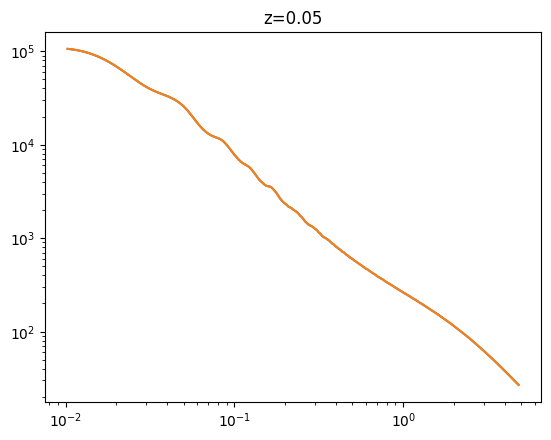

In [12]:
parent_dir = "/srv/scratch2/taylor.4264/odd_emu/production_run/merged"
k = np.load(parent_dir + "/k_0.npy")  # (262,)'')

from matplotlib import pyplot as plt
plt.plot(k, Pk_pred[0])
plt.plot(k, pk0)
plt.xscale('log')
plt.yscale('log')
plt.title('z=0.05')


Text(0.5, 1.0, 'z=0.0')

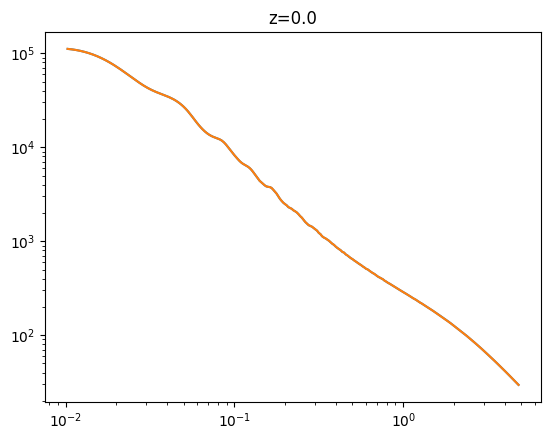

In [13]:
plt.plot(k, Pk_pred[99])
pk_all = jnp.load(os.path.join(parent_dir, f"pk_nl_{z_idx}.npy"))
plt.plot(k, pk_all[0, 0])
plt.xscale('log')
plt.yscale('log')
plt.title('z=0.0')

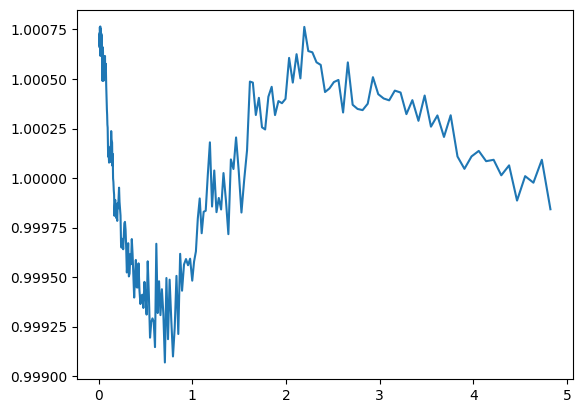

In [14]:
plt.plot(k, Pk_pred[99] / pk_all[0,0])

# Now let's try integrating through all the slices

In [1]:
import os
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
from diffrax import diffeqsolve, Dopri5, SaveAt, ODETerm

# --- Model definition (must match training) ---
class RHS(eqx.Module):
    mlp: eqx.nn.MLP
    def __init__(self, key):
        self.mlp = eqx.nn.MLP(in_size=265, out_size=262, width_size=512, depth=4, key=key)

    def __call__(self, P, H, rho, z):
        x = jnp.concatenate([P, H, rho, z])
        return self.mlp(x)

# --- Paths ---
model_dir = "/srv/scratch2/taylor.4264/odd_emu/production_models"
data_dir = "/srv/scratch2/taylor.4264/odd_emu/production_run/merged/"
n_chunks = 30  # from 0 to 61

# --- Load normalization constants from full arrays ---
Hz_all = jnp.concatenate([jnp.load(os.path.join(data_dir, f"Hz_{i}.npy")).astype(jnp.float32) for i in range(n_chunks)])
rho_all = jnp.concatenate([jnp.load(os.path.join(data_dir, f"rho_m_{i}.npy")).astype(jnp.float32) for i in range(n_chunks)])

H_mean = jnp.mean(Hz_all)
H_std = jnp.std(Hz_all)

log_rho_flat = jnp.log10(rho_all + 1e-30)
log_rho_mean = jnp.mean(log_rho_flat)
log_rho_std = jnp.std(log_rho_flat)

# --- Initial condition from highest redshift chunk ---
z_idx_start = n_chunks - 1
z_grid = jnp.load(os.path.join(data_dir, f"z_{z_idx_start}.npy"))
pk_all = jnp.load(os.path.join(data_dir, f"pk_nl_{z_idx_start}.npy"))
y0 = jnp.log1p(pk_all[0, 0])  # start at highest z in chunk

# --- Storage for outputs ---
z_all = []
pk_all = []

for i in reversed(range(n_chunks)):
    print(f"Processing chunk {i}...")

    # Load model
    model_file = os.path.join(model_dir, f"learned_model_rhom_zchunk_{i:02d}.eqx")
    model_template = RHS(jax.random.PRNGKey(0))
    model = eqx.tree_deserialise_leaves(model_file, model_template)

    # Load data
    z_grid = jnp.load(os.path.join(data_dir, f"z_{i}.npy"))
    Hz = jnp.load(os.path.join(data_dir, f"Hz_{i}.npy"))[0]
    rho_m = jnp.load(os.path.join(data_dir, f"rho_m_{i}.npy"))[0]

    # Normalize
    Hz = (Hz - H_mean) / H_std
    log_rho_m = (jnp.log10(rho_m + 1e-30) - log_rho_mean) / log_rho_std

    # Reverse for forward-in-time integration
    z_grid = z_grid[::-1]
    Hz = Hz[::-1]
    log_rho_m = log_rho_m[::-1]

    # Skip first entry if not the first chunk (to avoid double-counting)
    if i < z_idx_start:
        z_grid = z_grid[1:]
        Hz = Hz[1:]
        log_rho_m = log_rho_m[1:]

    # Interpolators
    def H_fn(z, z_grid=z_grid, Hz=Hz):
        return jnp.interp(z, z_grid, Hz)

    def rhom_fn(z, z_grid=z_grid, log_rho_m=log_rho_m):
        return jnp.interp(z, z_grid, log_rho_m)

    # RHS function
    def rhs(t, y, args):
        model, H_fn, rhom_fn = args
        H = H_fn(t)
        rho = rhom_fn(t)
        z = jnp.array([t])
        return model(y, jnp.array([H]), jnp.array([rho]), z)

    term = ODETerm(rhs)
    solver = Dopri5()
    saveat = SaveAt(ts=z_grid)

    sol = diffeqsolve(
        term,
        solver,
        t0=float(z_grid[0]),
        t1=float(z_grid[-1]),
        dt0=-1e-2,
        y0=y0,
        args=(model, H_fn, rhom_fn),
        saveat=saveat
    )

    y0 = sol.ys[-1]  # final state becomes initial condition for next chunk
    z_all.append(z_grid)
    pk_all.append(jnp.expm1(sol.ys))

# --- Final output ---
z_all = jnp.concatenate(z_all)
pk_all = jnp.concatenate(pk_all)
print("Integrated P(k,z) shape:", pk_all.shape)

Processing chunk 29...
Processing chunk 28...
Processing chunk 27...
Processing chunk 26...
Processing chunk 25...
Processing chunk 24...
Processing chunk 23...
Processing chunk 22...
Processing chunk 21...
Processing chunk 20...
Processing chunk 19...
Processing chunk 18...
Processing chunk 17...
Processing chunk 16...
Processing chunk 15...
Processing chunk 14...
Processing chunk 13...
Processing chunk 12...
Processing chunk 11...
Processing chunk 10...
Processing chunk 9...
Processing chunk 8...
Processing chunk 7...
Processing chunk 6...
Processing chunk 5...
Processing chunk 4...
Processing chunk 3...
Processing chunk 2...
Processing chunk 1...
Processing chunk 0...
Integrated P(k,z) shape: (2971, 262)


Text(0.5, 1.0, 'z=0.')

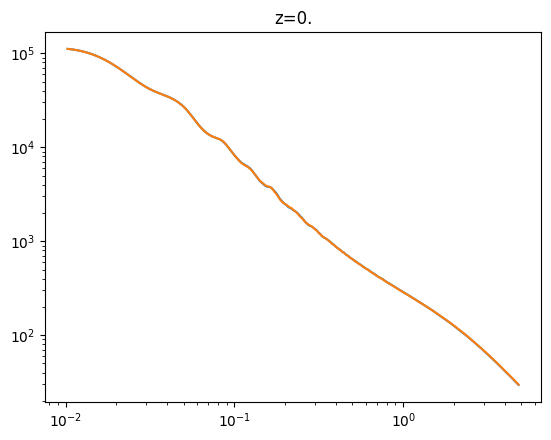

In [5]:
from matplotlib import pyplot as plt
pk0 = jnp.load(os.path.join(parent_dir, f"pk_nl_0.npy"))[0,0]

parent_dir = "/srv/scratch2/taylor.4264/odd_emu/production_run/merged"
k = np.load(parent_dir + "/k_0.npy")  # (262,)'')

plt.plot(k,pk0)
plt.plot(k,pk_all[-1])
plt.yscale('log')
plt.xscale('log')
plt.title('z=0.')

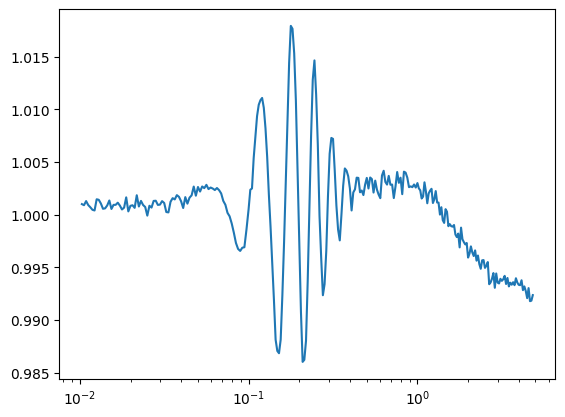

In [6]:
plt.plot(k, pk0 / pk_all[-1])
plt.xscale('log')
